In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import eng_to_ipa as p
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Load the data

In [2]:
df = pd.read_csv("avgRatings_annotated.csv")
df.drop(df.columns[7:22], axis = 1, inplace = True)
df.head()

,name,age,polarity,name_type,rating.mean_age,rating.mean_gender,rating.mean_valence,gender
0,Adelaide,old,NaN,real,-0.617647,45.727273,NaN,female
1,Adelina,NaN,bad,real,NaN,47.771429,31.621622,female
2,Alasdair,young,NaN,real,18.709677,-35.657143,NaN,male
3,Alastor,old,NaN,madeup,13.812500,-38.833333,NaN,male
4,Alecto,old,NaN,madeup,3.593750,-35.722222,NaN,female


## Vectorize

### Letter Features

In [3]:
def count_vector(word):
    alphabet_string = string.ascii_lowercase
    alphabet_list = list(alphabet_string)
    
    vector = []
    for i in range(len(alphabet_list)):
        vector.append(word.lower().count(alphabet_list[i]))
        
    return vector

df["letter_vec"] = pd.NaT

vector_list = []
for i in range(len(df["name"])):
    cv = count_vector(df.loc[i]["name"])
    vector_list.append(cv)
    
varray = np.array(vector_list, dtype=int)

for i in range(len(df["name"])):
    df["letter_vec"].loc[i] = varray[i]

C:\Users\gk200\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
feature_names_lf = list(string.ascii_lowercase)

### Phonological Features

In [5]:
ipa_temp = []

for name in df["name"].values:
    nipa = p.convert(name)
    if nipa[-1] == "*":
        ipa_temp.append("NA")
    else:
        ipa_temp.append(nipa)
  
print("NA value count: ", len([ipa_temp[i] for i in range(len(ipa_temp)) if ipa_temp[i] == "NA"]))
#print(ipa_temp)
df["IPA"] = ipa_temp

NA value count:  53


In [6]:
na_names_tr = pd.read_csv("na_names.csv")

for i in range(len(df["name"])):
    for j in range(len(na_names_tr["name"])):
        if df["name"].loc[i] == na_names_tr["name"][j]:
            df["IPA"].loc[i] = na_names_tr["IPA"][j]

In [7]:
feature_dict = {"Obstruents": ["t","d","s","z","ɬ","ɮ","θ","ð","c","ɟ","ç","ʝ"],
                "Fricatives": ["ɸ","β","f","v","θ","ð","s","z","ʃ","ʒ","ʂ","ʐ","ç","ʝ","x","ɣ","χ","ʁ","ħ","ʕ","h","ɦ"],
                "Lateral Fricatives": ["ɬ","ɮ"],
                "Plosives": ["p","b","t","d","ʈ","ɖ","c","ɟ","k","g","q","ɢ","ʔ"],
                "Nasals": ["m","ɱ","n","ɳ","ɲ","ŋ","ɴ"],
                "Approximants": ["ʋ","ɹ","ɻ","j","ɰ"],
                "Lateral Approximants": ["l","ɭ","ʎ","ʟ"],
                "Alveolars": ["t","d","n","r","ɾ","s","z","ɬ","ɮ","ɹ","l"],
                "Glottals": ["ʔ","h","ɦ"],
                "Dentals": ["θ","ð"],
                "Bilabials": ["p","b","m","ʙ","ɸ","β"],
                "Sonorants": ["m","ɱ","n","ɳ","ɲ","ŋ","ɴ","l","ʎ","r","ɹ","ʀ"],
                "Velars": ["k","ɡ","ŋ","x","ɣ","ɰ","ʟ"],
                "Voiced": ["b","m","ʙ","β","ɱ","ⱱ","v","ʋ","ð","d","n","r","ɾ","z","ɮ","ɹ","l","ʒ","ɖ","ɳ","ɽ","ʐ","ɻ","ɭ","ɟ","ɲ","ʝ","j","ʎ","ɡ","ŋ","ɣ","ɰ","ʟ","ɢ","ɴ","ʀ","ʁ","ʕ","ɦ"],
                "Voiceless": ["p","ɸ","f","θ","t","s","ɬ","ʃ","ʈ","ʂ","c","ç","k","x","q","χ","ħ","ʔ","h"],
                "High": ["i","y","ɪ","ʏ","ɨ","ʉ","ʊ","ɯ","u"],
                "Mid": ["e","ø","ɘ","ɵ","ɤ","o","ə","ɛ","œ","ɜ","ɞ","ʌ","ɔ"],
                "Low": ["æ","ɐ","a","ɶ","ɑ","ɒ"],
                "Front": ["i","y","ɪ","ʏ","e","ø","ɛ","œ","æ","a","ɶ"],
                "Central": ["ɨ","ʉ","ɘ","ɵ","ə","ɜ","ɞ","ɐ"],
                "Back": ["ɯ","u","ʊ","ɤ","o","ʌ","ɔ","ɑ","ɒ"],
                "Rounded": ["y","ʏ","ø","œ","ɶ","ʉ","ɵ","ɞ","u","o","ɔ","ɒ"],
                "Unrounded": ["i","e","ɪ","ɛ","a","ɨ","ɘ","ɜ","ɯ","ɤ","ʌ","ɑ"]}

In [8]:
feature_names_pf = list(feature_dict.keys())

In [9]:
def get_phonological_features(word_ipa, feature_dict):
    word_pv = np.zeros((1, len(feature_dict.keys())), dtype=int)
    word_pvdf = pd.DataFrame(word_pv, columns=list(feature_dict.keys()))
    for i in range(len(word_ipa)):
        for key in list(feature_dict.keys()):
            if word_ipa[i] in feature_dict[key]:
                word_pvdf[key][0] += 1
    return word_pvdf.iloc[0]

df["phonological_vec"] = pd.NaT

vector_list = []
for i in range(len(df["IPA"])):
    phv = np.array(get_phonological_features(df.loc[i]["IPA"], feature_dict), dtype=int)
    vector_list.append(phv)
    
varray = np.array(vector_list, dtype=int)
varray

for i in range(len(df["name"])):
    df["phonological_vec"].loc[i] = varray[i]

# Training

In [14]:
def train_RFR(input_df, feature_col, attribute_col):
    
    #cross-validation and model instantiations
    loo = LeaveOneOut()
    forest = RandomForestRegressor(random_state=7)
    
    #parameter grid and GridSearchCV (shuffle is false so random state is not actually needed but is there just in case)
    param_grid = {"n_estimators" : [25, 50, 75, 100], "max_depth" : [5, 8, 15, 25]}
    gs_rf = GridSearchCV(forest, param_grid, scoring="neg_mean_absolute_error", cv=KFold(3, random_state=7))
    
    
    #getting the data to be split
    xlist = [vector for vector in input_df[feature_col]]
    xarray = np.array(xlist, dtype=int)    

    X = xarray
    y = np.array(input_df[attribute_col],dtype=int)   
    
    #getting the names and their types of ease of use later on
    names = input_df["name"]
    types = input_df["name_type"]
    

    #list for the prediction of each name's rating
    predictions = []
    #feature importances list to store each (LOOCV) fold's feature importances
    importances = []
    
    #do the cross validation split (test is going to be only one name and train is going to be every other name but that)
    for train_index, test_index in loo.split(X):
        x_train = X[train_index]
        x_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
    
        #list with names in the test set and their type, again for easier use later
        test_names = list(names.iloc[test_index])
        test_name_types = list(types.iloc[test_index])
    
        #fit the model on this fold's training set
        model = gs_rf.fit(x_train,y_train)
        #predict the score for the test set (name)
        prediction = gs_rf.predict(x_test)

        #append the name, its type, its feature representation, its actual rating, 
        #and its predicted rating and prediction probability into the predictions list
        for i in range(len(x_test)):
            predictions.append((test_names[i],test_name_types[i],x_test[i],y_test[i],prediction[i]))
            
        #append the current (LOOCV) fold's best model's (according to GridSearch) feature importances into the importances list   
        importances.append(model.best_estimator_.feature_importances_)
        
    return predictions, importances

In [15]:
def train_LRR(input_df, feature_col, attribute_col):
    
    #cross-validation and model instantiations
    loo = LeaveOneOut()
    lr = LinearRegression()
    
    #getting the data to be split
    xlist = [vector for vector in input_df[feature_col]]
    xarray = np.array(xlist, dtype=int)    

    X = xarray
    y = np.array(input_df[attribute_col],dtype=int)   
    
    #getting the names and their types of ease of use later on
    names = input_df["name"]
    types = input_df["name_type"]
    

    #list for the prediction of each name's rating
    predictions = []
    #feature importances list to store each fold's feature importances
    importances = []
    
    #do the cross validation split (test is going to be only one name and train is going to be every other name but that)
    for train_index, test_index in loo.split(X):
        x_train = X[train_index]
        x_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
    
        #list with names in the test set and their type, again for easier use later
        test_names = list(names.iloc[test_index])
        test_name_types = list(types.iloc[test_index])
    
        #fit the model on this fold's training set
        model = lr.fit(x_train,y_train)
        #predict the score for the test set (name)
        prediction = lr.predict(x_test)

        #append the name, its type, its feature representation, its actual rating, and its predicted rating into the predictions list
        for i in range(len(x_test)):
            predictions.append((test_names[i],test_name_types[i],x_test[i],y_test[i],prediction[i]))
            
        weights = model.coef_
            
        #append the current fold's best model's (according to GridSearch) feature importances into the importances list   
        importances.append(weights)
        
    return predictions, importances

In [18]:
def metrics_and_eval(predictions):
    #predictions: the prediction list we get from the training functions with the names, their name types, their feature representation
    #             their actual values, and their predicted values 
    
    r2 = r2_score([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    mae = mean_absolute_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    mse = mean_squared_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    med_ae = median_absolute_error([predictions[i][3] for i in range(len(predictions))], [predictions[i][4] for i in range(len(predictions))])
    
    #-------------------------------------------------------------------------------------
    
    #split the absolute errors according to name type
    aes={"real":[], "talking":[], "madeup":[]}
    for i in range(len(predictions)):
        if predictions[i][1] == "real":
            aes["real"].append(abs(predictions[i][3] - predictions[i][4]))
        if predictions[i][1] == "talking":
            aes["talking"].append(abs(predictions[i][3] - predictions[i][4]))
        if predictions[i][1] == "madeup":
            aes["madeup"].append(abs(predictions[i][3] - predictions[i][4]))
            
    #take the average of the of the absolute error list for each name type
    avg_mae_per_nametype = {"real": np.mean(aes["real"]),
                            "talking": np.mean(aes["talking"]) ,
                            "madeup": np.mean(aes["madeup"])}
        
    
    return mae, avg_mae_per_nametype, r2, aes, mse, med_ae

## Polarity

In [13]:
pol_df = df.loc[df['polarity'].notnull(), ["name",  "name_type", "polarity", "rating.mean_valence", "letter_vec", "phonological_vec"]]
pol_df.reset_index(drop=True, inplace=True)

### Random Forest

In [19]:
RFLF_pol = train_RFR(pol_df, "letter_vec", "rating.mean_valence")
RFLFPOL_results = metrics_and_eval(RFLF_pol[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [20]:
print("Avg MAE: ", RFLFPOL_results[0], "Avg MAE per name type: ", RFLFPOL_results[1], "R2: ", RFLFPOL_results[2], 
      "Avg MSE: ", RFLFPOL_results[4], "Median AE: ", RFLFPOL_results[5], sep="\n")

Avg MAE: 
15.029873645832486
Avg MAE per name type: 
{'real': 12.36977808422442, 'talking': 14.202232156141147, 'madeup': 18.06268847304937}
R2: 
0.09314857093963225
Avg MSE: 
335.35863940911753
Median AE: 
14.10069264069264


In [21]:
RFPF_pol = train_RFR(pol_df, "phonological_vec", "rating.mean_valence")
RFPFPOL_results = metrics_and_eval(RFPF_pol[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [22]:
print("Avg MAE: ", RFPFPOL_results[0], "Avg MAE per name type: ", RFPFPOL_results[1], "R2: ", RFPFPOL_results[2], 
      "Avg MSE: ", RFPFPOL_results[4], "Median AE: ", RFPFPOL_results[5], sep="\n")

Avg MAE: 
14.626985864509674
Avg MAE per name type: 
{'real': 14.000128720355704, 'talking': 13.710172176107879, 'madeup': 15.969308327601642}
R2: 
0.1359935518356593
Avg MSE: 
319.51433014482154
Median AE: 
13.66


In [23]:
RFRLFPOL_pred = pd.DataFrame(RFLF_pol[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
RFRLFPOL_pred["Features"] = ["Letter" for i in range(len(RFLF_pol[0]))]

RFRPFPOL_pred = pd.DataFrame(RFPF_pol[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
RFRPFPOL_pred["Features"] = ["Phonological" for i in range(len(RFPF_pol[0]))]

RFRPOL_pred = RFRLFPOL_pred.append(RFRPFPOL_pred)

In [93]:
#RFRPOL_pred.to_csv("RFRPOLpred.csv")

[Text(0.5, 1.0, 'Polarity')]

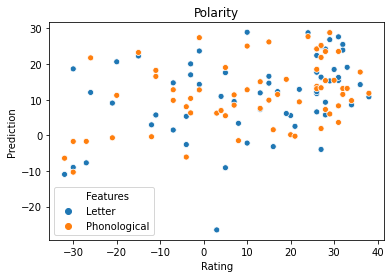

In [24]:
sns.scatterplot(x=RFRPOL_pred["Rating"], y=RFRPOL_pred["Prediction"], hue=RFRPOL_pred["Features"]).set(title='Polarity')

In [25]:
#gather results in data frames
RFR_pol_ae_lf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in RFLFPOL_results[3].keys():
    for i in range(len(RFLFPOL_results[3][key])):
        app = pd.DataFrame({"AEs":RFLFPOL_results[3][key][i], "NameType":key, "Feature":["Letter"]})
        RFR_pol_ae_lf = RFR_pol_ae_lf.append(app, ignore_index=True)
        
RFR_pol_ae_pf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in RFPFPOL_results[3].keys():
    for i in range(len(RFPFPOL_results[3][key])):
        app = pd.DataFrame({"AEs":RFPFPOL_results[3][key][i], "NameType": key, "Feature": ["Phonological"]})
        RFR_pol_ae_pf = RFR_pol_ae_pf.append(app, ignore_index=True)
        
RFR_pol_ae = RFR_pol_ae_lf.append(RFR_pol_ae_pf)

In [94]:
#RFR_pol_ae.to_csv("RFR_pol_ae.csv")

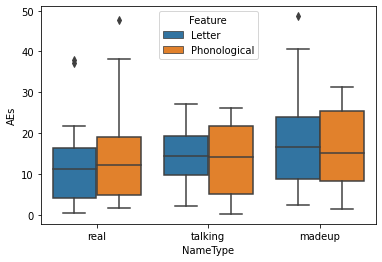

In [26]:
sns.boxplot(x="NameType", y="AEs", hue="Feature", data=RFR_pol_ae)

In [30]:
RFR_lf_mae_pol_df = pd.DataFrame({"NameType": [list(RFLFPOL_results[1].keys())[i] for i in range(len(RFLFPOL_results[1].keys()))], "MAE": [list(RFLFPOL_results[1].values())[i] for i in range(len(RFLFPOL_results[1].values()))], "Features": ["Letter" for i in range(len(RFLFPOL_results[1].items()))]})
RFR_pf_mae_pol_df = pd.DataFrame({"NameType": [list(RFPFPOL_results[1].keys())[i] for i in range(len(RFPFPOL_results[1].keys()))], "MAE": [list(RFPFPOL_results[1].values())[i] for i in range(len(RFPFPOL_results[1].values()))], "Features": ["Phonological" for i in range(len(RFPFPOL_results[1].items()))]})
RFR_mae_pol_df = RFR_lf_mae_pol_df.append(RFR_pf_mae_pol_df)

In [95]:
#RFR_mae_pol_df.to_csv("RFR_mae_pol_df.csv")

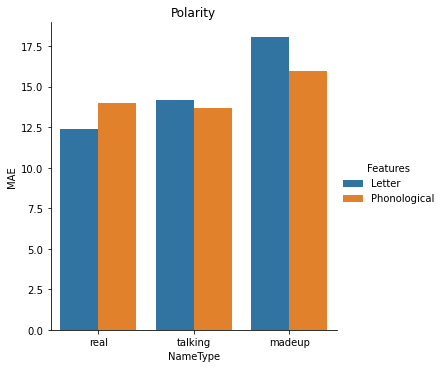

In [32]:
sns.catplot(data=RFR_mae_pol_df, kind="bar", x="NameType", y="MAE", hue="Features").set(title='Polarity')

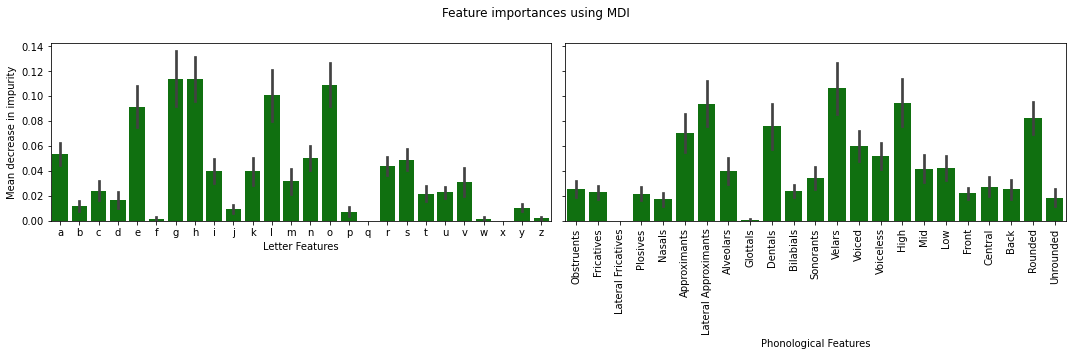

In [33]:
importances_lf = pd.DataFrame(data=RFLF_pol[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=RFPF_pol[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances using MDI")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Mean decrease in impurity")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Logistic Regression

In [34]:
LRLF_pol = train_LRR(pol_df, "letter_vec", "rating.mean_valence")
LRLFPOL_results = metrics_and_eval(LRLF_pol[0])

In [35]:
print("Avg MAE: ", LRLFPOL_results[0], "Avg MAE per name type: ", LRLFPOL_results[1], "R2: ", LRLFPOL_results[2], 
      "Avg MSE: ", LRLFPOL_results[4], "Median AE: ", LRLFPOL_results[5], sep="\n")

Avg MAE: 
16.80943203285179
Avg MAE per name type: 
{'real': 11.90274687828655, 'talking': 18.347059001558094, 'madeup': 19.739047846642176}
R2: 
-0.12749161871333015
Avg MSE: 
416.9525934238953
Median AE: 
13.526053490946001


In [36]:
LRPF_pol = train_LRR(pol_df, "phonological_vec", "rating.mean_valence")
LRPFPOL_results = metrics_and_eval(LRPF_pol[0])

In [37]:
print("Avg MAE: ", LRPFPOL_results[0], "Avg MAE per name type: ", LRPFPOL_results[1], "R2: ", LRPFPOL_results[2], 
      "Avg MSE: ", LRPFPOL_results[4], "Median AE: ", LRPFPOL_results[5], sep="\n")

Avg MAE: 
15.793926501825172
Avg MAE per name type: 
{'real': 13.835336751711619, 'talking': 15.873987413838268, 'madeup': 17.427429839303834}
R2: 
0.009847112930632673
Avg MSE: 
366.163976119718
Median AE: 
16.8529722718945


In [38]:
LRRLFPOL_pred = pd.DataFrame(LRLF_pol[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
LRRLFPOL_pred["Features"] = ["Letter" for i in range(len(LRLF_pol[0]))]

LRRPFPOL_pred = pd.DataFrame(LRPF_pol[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
LRRPFPOL_pred["Features"] = ["Phonological" for i in range(len(LRPF_pol[0]))]

LRRPOL_pred = LRRLFPOL_pred.append(LRRPFPOL_pred)

In [96]:
#LRRPOL_pred.to_csv("LRRPOL_pred.csv")

[Text(0.5, 1.0, 'Polarity')]

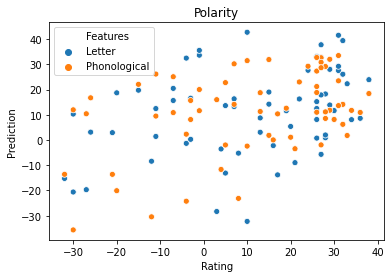

In [39]:
sns.scatterplot(x=LRRPOL_pred["Rating"], y=LRRPOL_pred["Prediction"], hue=LRRPOL_pred["Features"]).set(title='Polarity')

In [40]:
LRR_pol_ae_lf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in LRLFPOL_results[3].keys():
    for i in range(len(LRLFPOL_results[3][key])):
        app = pd.DataFrame({"AEs":LRLFPOL_results[3][key][i], "NameType":key, "Feature":["Letter"]})
        LRR_pol_ae_lf = LRR_pol_ae_lf.append(app, ignore_index=True)
        
LRR_pol_ae_pf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in LRPFPOL_results[3].keys():
    for i in range(len(LRPFPOL_results[3][key])):
        app = pd.DataFrame({"AEs":LRPFPOL_results[3][key][i], "NameType": key, "Feature": ["Phonological"]})
        LRR_pol_ae_pf = LRR_pol_ae_pf.append(app, ignore_index=True)
        
LRR_pol_ae = LRR_pol_ae_lf.append(LRR_pol_ae_pf)

In [98]:
#LRR_pol_ae.to_csv("LRR_pol_ae.csv")

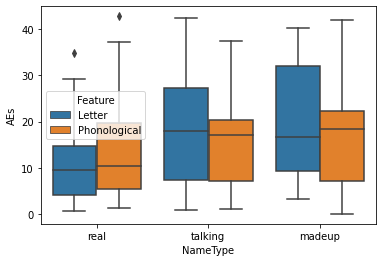

In [41]:
sns.boxplot(x="NameType", y="AEs", hue="Feature", data=LRR_pol_ae)

In [42]:
LRR_lf_mae_pol_df = pd.DataFrame({"NameType": [list(LRLFPOL_results[1].keys())[i] for i in range(len(LRLFPOL_results[1].keys()))], "MAE": [list(LRLFPOL_results[1].values())[i] for i in range(len(LRLFPOL_results[1].values()))], "Features": ["Letter" for i in range(len(LRLFPOL_results[1].items()))]})
LRR_pf_mae_pol_df = pd.DataFrame({"NameType": [list(LRPFPOL_results[1].keys())[i] for i in range(len(LRPFPOL_results[1].keys()))], "MAE": [list(LRPFPOL_results[1].values())[i] for i in range(len(LRPFPOL_results[1].values()))], "Features": ["Phonological" for i in range(len(LRPFPOL_results[1].items()))]})
LRR_mae_pol_df = LRR_lf_mae_pol_df.append(LRR_pf_mae_pol_df)

In [97]:
#LRR_mae_pol_df.to_csv("LRR_mae_pol_df.csv")

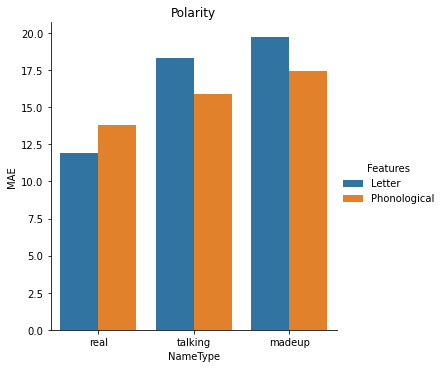

In [43]:
sns.catplot(data=LRR_mae_pol_df, kind="bar", x="NameType", y="MAE", hue="Features").set(title='Polarity')

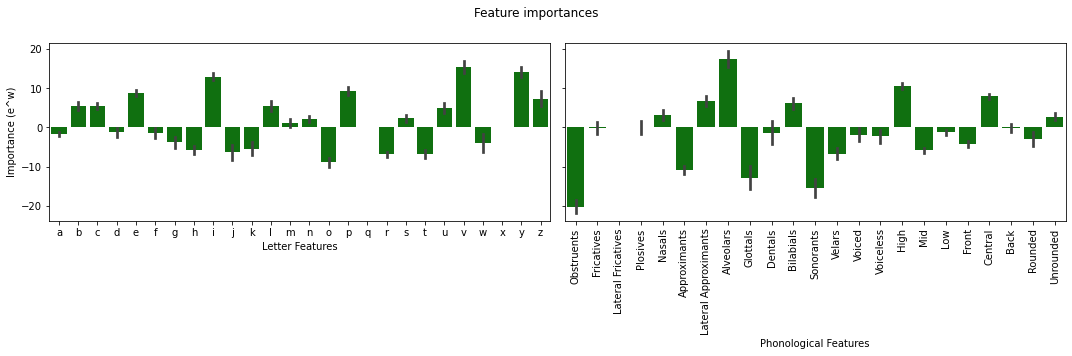

In [44]:
importances_lf = pd.DataFrame(data=LRLF_pol[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=LRPF_pol[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Importance (e^w)")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Gender

In [45]:
gen_df = df.loc[df['gender'].notnull(), ["name", "name_type","gender", "rating.mean_gender", "letter_vec", "phonological_vec"]]
gen_df.reset_index(drop=True, inplace=True)

### Random Forest

In [46]:
RFLF_gen = train_RFR(gen_df, "letter_vec", "rating.mean_gender")
RFLFGEN_results = metrics_and_eval(RFLF_gen[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [47]:
print("Avg MAE: ", RFLFGEN_results[0], "Avg MAE per name type: ", RFLFGEN_results[1], "R2: ", RFLFGEN_results[2], 
      "Avg MSE: ", RFLFGEN_results[4], "Median AE: ", RFLFGEN_results[5], sep="\n")

Avg MAE: 
31.926487390701123
Avg MAE per name type: 
{'real': 39.0595915386288, 'talking': 30.43794756301872, 'madeup': 26.544502205848143}
R2: 
0.005572035998342106
Avg MSE: 
1319.9083551110466
Median AE: 
31.36882718138318


In [48]:
RFPF_gen = train_RFR(gen_df, "phonological_vec", "rating.mean_gender")
RFPFGEN_results = metrics_and_eval(RFPF_gen[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [49]:
print("Avg MAE: ", RFPFGEN_results[0], "Avg MAE per name type: ", RFPFGEN_results[1], "R2: ", RFPFGEN_results[2], 
      "Avg MSE: ", RFPFGEN_results[4], "Median AE: ", RFPFGEN_results[5], sep="\n")

Avg MAE: 
28.586798658652462
Avg MAE per name type: 
{'real': 35.21653041812212, 'talking': 25.833051461039723, 'madeup': 24.977700942071422}
R2: 
0.15024637444349664
Avg MSE: 
1127.8815065140932
Median AE: 
27.92


In [50]:
RFRLFGEN_pred = pd.DataFrame(RFLF_gen[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
RFRLFGEN_pred["Features"] = ["Letter" for i in range(len(RFLF_gen[0]))]

RFRPFGEN_pred = pd.DataFrame(RFPF_gen[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
RFRPFGEN_pred["Features"] = ["Phonological" for i in range(len(RFPF_gen[0]))]

RFRGEN_pred = RFRLFGEN_pred.append(RFRPFGEN_pred)

In [99]:
#RFRGEN_pred.to_csv("RFRGEN_pred.csv")

[Text(0.5, 1.0, 'Gender')]

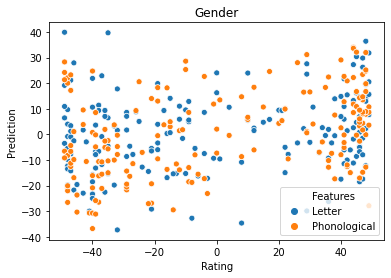

In [51]:
sns.scatterplot(x=RFRGEN_pred["Rating"], y=RFRGEN_pred["Prediction"], hue=RFRGEN_pred["Features"]).set(title='Gender')

In [52]:
RFR_gen_ae_lf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in RFLFGEN_results[3].keys():
    for i in range(len(RFLFGEN_results[3][key])):
        app = pd.DataFrame({"AEs":RFLFGEN_results[3][key][i], "NameType":key, "Feature":["Letter"]})
        RFR_gen_ae_lf = RFR_gen_ae_lf.append(app, ignore_index=True)
        
RFR_gen_ae_pf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in RFPFGEN_results[3].keys():
    for i in range(len(RFPFGEN_results[3][key])):
        app = pd.DataFrame({"AEs":RFPFGEN_results[3][key][i], "NameType": key, "Feature": ["Phonological"]})
        RFR_gen_ae_pf = RFR_gen_ae_pf.append(app, ignore_index=True)
        
RFR_gen_ae = RFR_gen_ae_lf.append(RFR_gen_ae_pf)

In [100]:
#RFR_gen_ae.to_csv("RFR_gen_ae.csv")

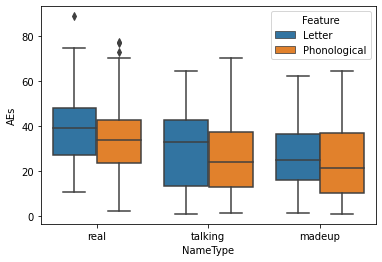

In [53]:
sns.boxplot(x="NameType", y="AEs", hue="Feature", data=RFR_gen_ae)

In [54]:
RFR_lf_mae_gen_df = pd.DataFrame({"NameType": [list(RFLFGEN_results[1].keys())[i] for i in range(len(RFLFGEN_results[1].keys()))], "MAE": [list(RFLFGEN_results[1].values())[i] for i in range(len(RFLFGEN_results[1].values()))], "Features": ["Letter" for i in range(len(RFLFGEN_results[1].items()))]})
RFR_pf_mae_gen_df = pd.DataFrame({"NameType": [list(RFPFGEN_results[1].keys())[i] for i in range(len(RFPFGEN_results[1].keys()))], "MAE": [list(RFPFGEN_results[1].values())[i] for i in range(len(RFPFGEN_results[1].values()))], "Features": ["Phonological" for i in range(len(RFPFGEN_results[1].items()))]})
RFR_mae_gen_df = RFR_lf_mae_gen_df.append(RFR_pf_mae_gen_df)

In [101]:
#RFR_mae_gen_df.to_csv("RFR_mae_gen_df.csv")

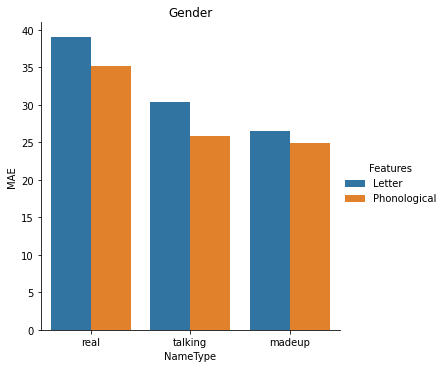

In [55]:
sns.catplot(data=RFR_mae_gen_df, kind="bar", x="NameType", y="MAE", hue="Features").set(title='Gender')

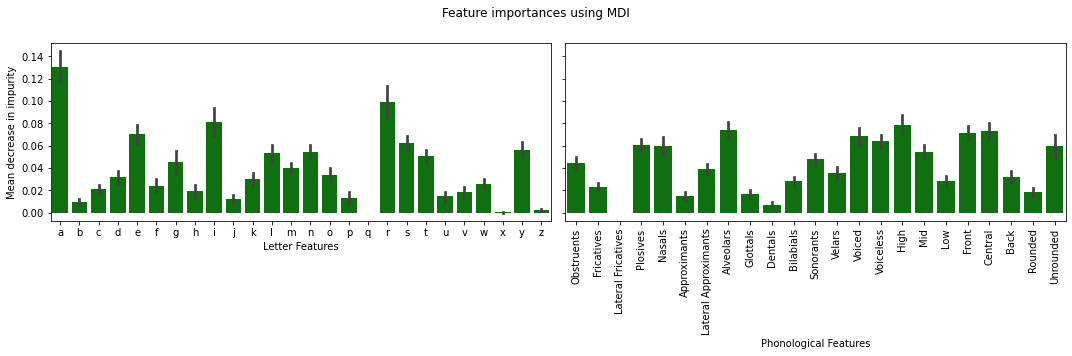

In [56]:
importances_lf = pd.DataFrame(data=RFLF_gen[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=RFPF_gen[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances using MDI")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Mean decrease in impurity")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Logistic Regression

In [57]:
LRLF_gen = train_LRR(gen_df, "letter_vec", "rating.mean_gender")
LRLFGEN_results = metrics_and_eval(LRLF_gen[0])

In [58]:
print("Avg MAE: ", LRLFGEN_results[0], "Avg MAE per name type: ", LRLFGEN_results[1], "R2: ", LRLFGEN_results[2], 
      "Avg MSE: ", LRLFGEN_results[4], "Median AE: ", LRLFGEN_results[5], sep="\n")

Avg MAE: 
28.620943451368817
Avg MAE per name type: 
{'real': 36.50649739669077, 'talking': 27.011109897687348, 'madeup': 22.634905417133762}
R2: 
0.0924098115874663
Avg MSE: 
1204.648215926996
Median AE: 
25.491091789976167


In [59]:
LRPF_gen = train_LRR(gen_df, "phonological_vec", "rating.mean_gender")
LRPFGEN_results = metrics_and_eval(LRPF_gen[0])

In [60]:
print("Avg MAE: ", LRPFGEN_results[0], "Avg MAE per name type: ", LRPFGEN_results[1], "R2: ", LRPFGEN_results[2], 
      "Avg MSE: ", LRPFGEN_results[4], "Median AE: ", LRPFGEN_results[5], sep="\n")

Avg MAE: 
30.43515124883345
Avg MAE per name type: 
{'real': 39.157199684508605, 'talking': 26.382677972851113, 'madeup': 26.123852258262843}
R2: 
-0.010309942878787393
Avg MSE: 
1340.9885714509658
Median AE: 
26.810987329359293


In [61]:
LRRLFGEN_pred = pd.DataFrame(LRLF_gen[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
LRRLFGEN_pred["Features"] = ["Letter" for i in range(len(LRLF_gen[0]))]

LRRPFGEN_pred = pd.DataFrame(LRPF_gen[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
LRRPFGEN_pred["Features"] = ["Phonological" for i in range(len(LRPF_gen[0]))]

LRRGEN_pred = LRRLFGEN_pred.append(LRRPFGEN_pred)

In [102]:
#LRRGEN_pred.to_csv("LRRGEN_pred.csv")

[Text(0.5, 1.0, 'Gender')]

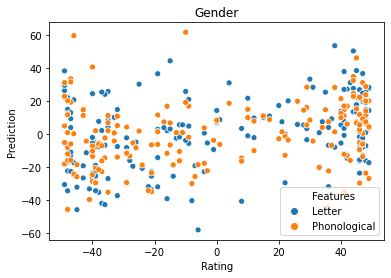

In [62]:
sns.scatterplot(x=LRRGEN_pred["Rating"], y=LRRGEN_pred["Prediction"], hue=LRRGEN_pred["Features"]).set(title='Gender')

In [63]:
LRR_gen_ae_lf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in LRLFGEN_results[3].keys():
    for i in range(len(LRLFGEN_results[3][key])):
        app = pd.DataFrame({"AEs":LRLFGEN_results[3][key][i], "NameType":key, "Feature":["Letter"]})
        LRR_gen_ae_lf = LRR_gen_ae_lf.append(app, ignore_index=True)
        
LRR_gen_ae_pf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in LRPFGEN_results[3].keys():
    for i in range(len(LRPFGEN_results[3][key])):
        app = pd.DataFrame({"AEs":LRPFGEN_results[3][key][i], "NameType": key, "Feature": ["Phonological"]})
        LRR_gen_ae_pf = LRR_gen_ae_pf.append(app, ignore_index=True)
        
LRR_gen_ae = LRR_gen_ae_lf.append(LRR_gen_ae_pf)

In [103]:
#LRR_gen_ae.to_csv("LRR_gen_ae.csv")

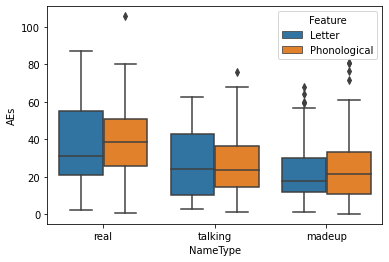

In [64]:
sns.boxplot(x="NameType", y="AEs", hue="Feature", data=LRR_gen_ae)

In [65]:
LRR_lf_mae_gen_df = pd.DataFrame({"NameType": [list(LRLFGEN_results[1].keys())[i] for i in range(len(LRLFGEN_results[1].keys()))], "MAE": [list(LRLFGEN_results[1].values())[i] for i in range(len(LRLFGEN_results[1].values()))], "Features": ["Letter" for i in range(len(LRLFGEN_results[1].items()))]})
LRR_pf_mae_gen_df = pd.DataFrame({"NameType": [list(LRPFGEN_results[1].keys())[i] for i in range(len(LRPFGEN_results[1].keys()))], "MAE": [list(LRPFGEN_results[1].values())[i] for i in range(len(LRPFGEN_results[1].values()))], "Features": ["Phonological" for i in range(len(LRPFGEN_results[1].items()))]})
LRR_mae_gen_df = LRR_lf_mae_gen_df.append(LRR_pf_mae_gen_df)

In [104]:
#LRR_mae_gen_df.to_csv("LRR_mae_gen_df.csv")

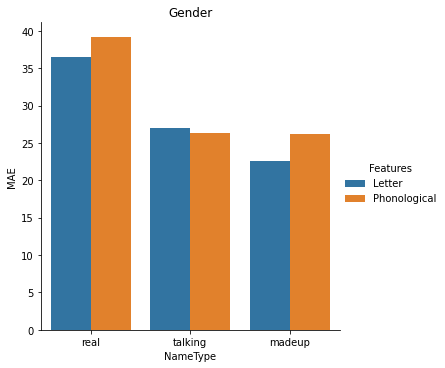

In [66]:
sns.catplot(data=LRR_mae_gen_df, kind="bar", x="NameType", y="MAE", hue="Features").set(title='Gender')

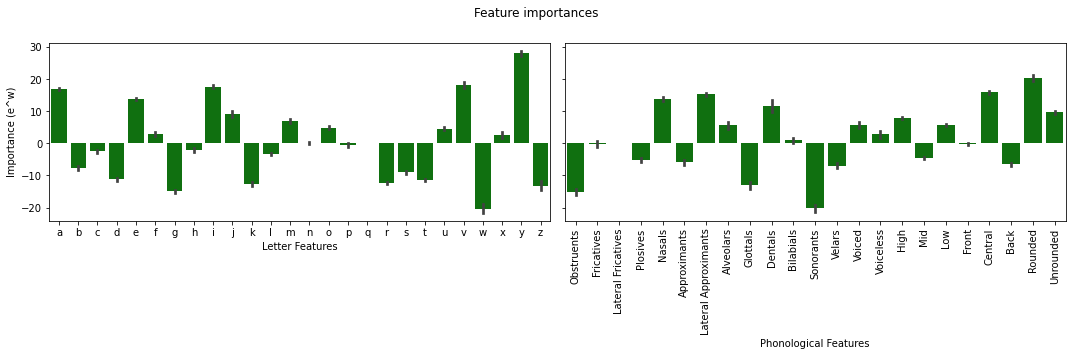

In [67]:
importances_lf = pd.DataFrame(data=LRLF_gen[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=LRPF_gen[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Importance (e^w)")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Age

In [68]:
age_df = df.loc[df['age'].notnull(), ["name", "name_type", "age", "rating.mean_age", "letter_vec", "phonological_vec"]]
age_df.reset_index(drop=True, inplace=True)

### Random Forest

In [69]:
RFLF_age = train_RFR(age_df, "letter_vec", "rating.mean_age")
RFLFAGE_results = metrics_and_eval(RFLF_age[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [71]:
print("Avg MAE: ", RFLFAGE_results[0], "Avg MAE per name type: ", RFLFAGE_results[1], "R2: ", RFLFAGE_results[2], 
      "Avg MSE: ", RFLFAGE_results[4], "Median AE: ", RFLFAGE_results[5], sep="\n")

Avg MAE: 
16.214352939215292
Avg MAE per name type: 
{'real': 17.17238937238692, 'talking': 17.654569756940678, 'madeup': 13.651975390436192}
R2: 
0.009477192802523904
Avg MSE: 
392.4045528253864
Median AE: 
14.113049768121162


In [72]:
RFPF_age = train_RFR(age_df, "phonological_vec", "rating.mean_age")
RFPFAGE_results = metrics_and_eval(RFPF_age[0])

C:\Users\gk200\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [73]:
print("Avg MAE: ", RFPFAGE_results[0], "Avg MAE per name type: ", RFPFAGE_results[1], "R2: ", RFPFAGE_results[2], 
      "Avg MSE: ", RFPFAGE_results[4], "Median AE: ", RFPFAGE_results[5], sep="\n")

Avg MAE: 
17.17998431610636
Avg MAE per name type: 
{'real': 14.857482272074241, 'talking': 20.418111801800816, 'madeup': 16.13095418052247}
R2: 
-0.09606132383303301
Avg MSE: 
434.2145890257683
Median AE: 
15.02256983546929


In [74]:
RFRLFAGE_pred = pd.DataFrame(RFLF_age[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
RFRLFAGE_pred["Features"] = ["Letter" for i in range(len(RFLF_age[0]))]

RFRPFAGE_pred = pd.DataFrame(RFPF_age[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
RFRPFAGE_pred["Features"] = ["Phonological" for i in range(len(RFPF_age[0]))]

RFRAGE_pred = RFRLFAGE_pred.append(RFRPFAGE_pred)

In [105]:
#RFRAGE_pred.to_csv("RFRAGE_pred.csv")

[Text(0.5, 1.0, 'Age')]

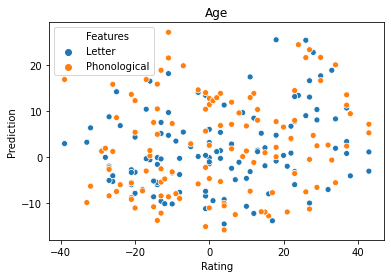

In [75]:
sns.scatterplot(x=RFRAGE_pred["Rating"], y=RFRAGE_pred["Prediction"], hue=RFRAGE_pred["Features"]).set(title='Age')

In [76]:
RFR_age_ae_lf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in RFLFAGE_results[3].keys():
    for i in range(len(RFLFAGE_results[3][key])):
        app = pd.DataFrame({"AEs":RFLFAGE_results[3][key][i], "NameType":key, "Feature":["Letter"]})
        RFR_age_ae_lf = RFR_age_ae_lf.append(app, ignore_index=True)
        
RFR_age_ae_pf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in RFPFAGE_results[3].keys():
    for i in range(len(RFPFAGE_results[3][key])):
        app = pd.DataFrame({"AEs":RFPFAGE_results[3][key][i], "NameType": key, "Feature": ["Phonological"]})
        RFR_age_ae_pf = RFR_age_ae_pf.append(app, ignore_index=True)
        
RFR_age_ae = RFR_age_ae_lf.append(RFR_age_ae_pf)

In [106]:
#RFR_age_ae.to_csv("RFR_age_ae.csv")

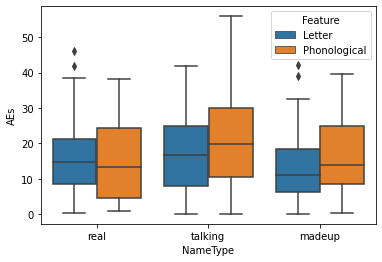

In [77]:
sns.boxplot(x="NameType", y="AEs", hue="Feature", data=RFR_age_ae)

In [78]:
RFR_lf_mae_age_df = pd.DataFrame({"NameType": [list(RFLFAGE_results[1].keys())[i] for i in range(len(RFLFAGE_results[1].keys()))], "MAE": [list(RFLFAGE_results[1].values())[i] for i in range(len(RFLFAGE_results[1].values()))], "Features": ["Letter" for i in range(len(RFLFAGE_results[1].items()))]})
RFR_pf_mae_age_df = pd.DataFrame({"NameType": [list(RFPFAGE_results[1].keys())[i] for i in range(len(RFPFAGE_results[1].keys()))], "MAE": [list(RFPFAGE_results[1].values())[i] for i in range(len(RFPFAGE_results[1].values()))], "Features": ["Phonological" for i in range(len(RFPFAGE_results[1].items()))]})
RFR_mae_age_df = RFR_lf_mae_age_df.append(RFR_pf_mae_age_df)

In [107]:
#RFR_mae_age_df.to_csv("RFR_mae_age_df.csv")

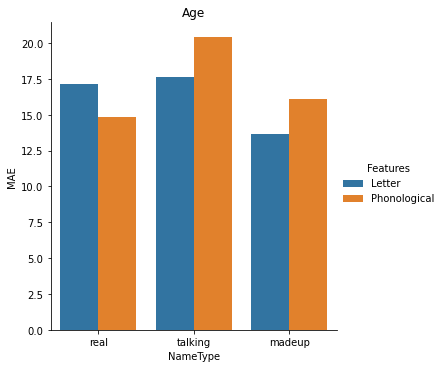

In [79]:
sns.catplot(data=RFR_mae_age_df, kind="bar", x="NameType", y="MAE", hue="Features").set(title='Age')

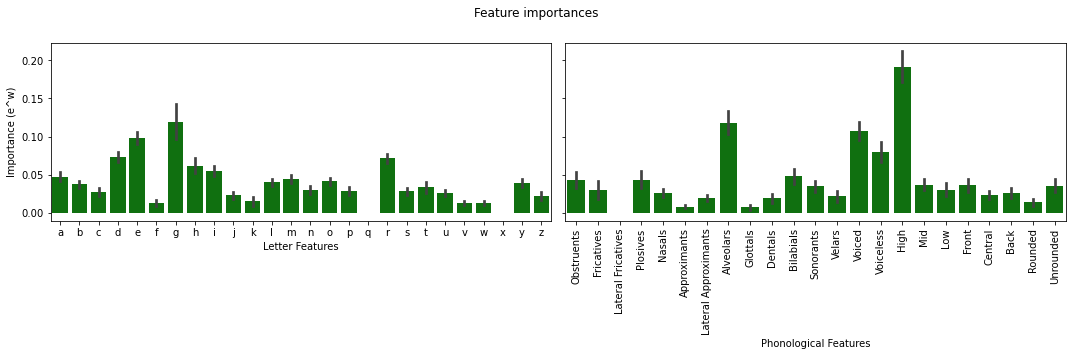

In [80]:
importances_lf = pd.DataFrame(data=RFLF_age[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=RFPF_age[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Importance (e^w)")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

### Logistic Regression

In [81]:
LRLF_age = train_LRR(age_df, "letter_vec", "rating.mean_age")
LRLFAGE_results = metrics_and_eval(LRLF_age[0])

In [83]:
print("Avg MAE: ", LRLFAGE_results[0], "Avg MAE per name type: ", LRLFAGE_results[1], "R2: ", LRLFAGE_results[2], 
      "Avg MSE: ", LRLFAGE_results[4], "Median AE: ", LRLFAGE_results[5], sep="\n")

Avg MAE: 
16.832632807765837
Avg MAE per name type: 
{'real': 18.654564460099053, 'talking': 18.116644622092643, 'madeup': 13.529428847746688}
R2: 
-0.13376965695213938
Avg MSE: 
449.1530856336951
Median AE: 
14.05040719744769


In [84]:
LRPF_age = train_LRR(age_df, "phonological_vec", "rating.mean_age")
LRPFAGE_results = metrics_and_eval(LRPF_age[0])

In [85]:
print("Avg MAE: ", LRPFAGE_results[0], "Avg MAE per name type: ", LRPFAGE_results[1], "R2: ", LRPFAGE_results[2], 
      "Avg MSE: ", LRPFAGE_results[4], "Median AE: ", LRPFAGE_results[5], sep="\n")

Avg MAE: 
18.165084198274805
Avg MAE per name type: 
{'real': 18.33787663110983, 'talking': 19.904621748921002, 'madeup': 16.106327964330205}
R2: 
-0.20886809312665844
Avg MSE: 
478.9040091367345
Median AE: 
17.790463982819357


In [86]:
LRRLFAGE_pred = pd.DataFrame(LRLF_age[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
LRRLFAGE_pred["Features"] = ["Letter" for i in range(len(LRLF_age[0]))]

LRRPFAGE_pred = pd.DataFrame(LRPF_age[0], columns=["Name", "Name Type", "Feature Rep", "Rating", "Prediction"])
LRRPFAGE_pred["Features"] = ["Phonological" for i in range(len(LRPF_age[0]))]

LRRAGE_pred = LRRLFAGE_pred.append(LRRPFAGE_pred)

In [108]:
#LRRAGE_pred.to_csv("LRRAGE_pred.csv")

[Text(0.5, 1.0, 'Age')]

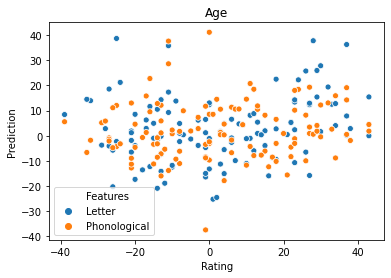

In [87]:
sns.scatterplot(x=LRRAGE_pred["Rating"], y=LRRAGE_pred["Prediction"], hue=LRRAGE_pred["Features"]).set(title='Age')

In [88]:
LRR_age_ae_lf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in LRLFAGE_results[3].keys():
    for i in range(len(LRLFAGE_results[3][key])):
        app = pd.DataFrame({"AEs":LRLFAGE_results[3][key][i], "NameType":key, "Feature":["Letter"]})
        LRR_age_ae_lf = LRR_age_ae_lf.append(app, ignore_index=True)
        
LRR_age_ae_pf = pd.DataFrame(columns=["AEs", "NameType", "Feature"])

for key in LRPFAGE_results[3].keys():
    for i in range(len(LRPFAGE_results[3][key])):
        app = pd.DataFrame({"AEs":LRPFAGE_results[3][key][i], "NameType": key, "Feature": ["Phonological"]})
        LRR_age_ae_pf = LRR_age_ae_pf.append(app, ignore_index=True)
        
LRR_age_ae = LRR_age_ae_lf.append(LRR_age_ae_pf)

In [109]:
#LRR_age_ae.to_csv("LRR_age_ae.csv")

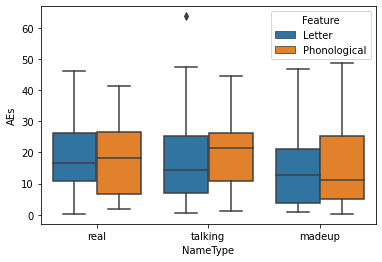

In [89]:
sns.boxplot(x="NameType", y="AEs", hue="Feature", data=LRR_age_ae)

In [90]:
LRR_lf_mae_age_df = pd.DataFrame({"NameType": [list(LRLFAGE_results[1].keys())[i] for i in range(len(LRLFAGE_results[1].keys()))], "MAE": [list(LRLFAGE_results[1].values())[i] for i in range(len(LRLFAGE_results[1].values()))], "Features": ["Letter" for i in range(len(LRLFAGE_results[1].items()))]})
LRR_pf_mae_age_df = pd.DataFrame({"NameType": [list(LRPFAGE_results[1].keys())[i] for i in range(len(LRPFAGE_results[1].keys()))], "MAE": [list(LRPFAGE_results[1].values())[i] for i in range(len(LRPFAGE_results[1].values()))], "Features": ["Phonological" for i in range(len(LRPFAGE_results[1].items()))]})
LRR_mae_age_df = LRR_lf_mae_age_df.append(LRR_pf_mae_age_df)

In [110]:
#LRR_mae_age_df.to_csv("LRR_mae_age_df.csv")

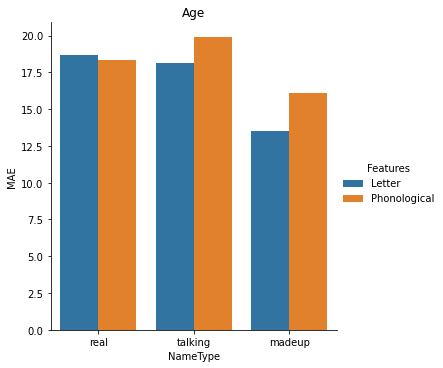

In [91]:
sns.catplot(data=LRR_mae_age_df, kind="bar", x="NameType", y="MAE", hue="Features").set(title='Age')

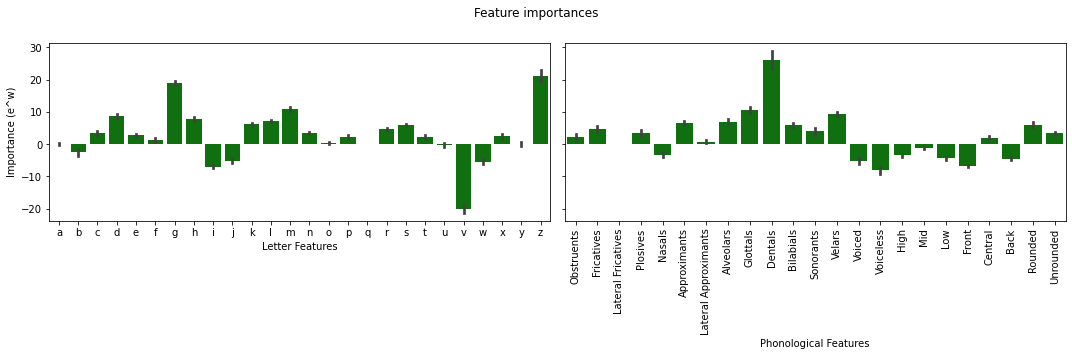

In [92]:
importances_lf = pd.DataFrame(data=LRLF_age[1], columns=feature_names_lf)
importances_lf["Features"] = ["Letter" for i in range(len(importances_lf))]

importances_pf = pd.DataFrame(data=LRPF_age[1], columns=feature_names_pf)
importances_pf["Features"] = ["Phonological" for i in range(len(importances_pf))]

fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.barplot(ax=axes[0],data=importances_lf , ci="sd", color="green")
sns.barplot(ax=axes[1],data=importances_pf , ci="sd", color="green")

fig.suptitle("Feature importances")
axes[0].set_xlabel("Letter Features")
axes[1].set_xlabel("Phonological Features")
axes[0].set_ylabel("Importance (e^w)")

plt.xticks(rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.88)